In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets

In [3]:
image_size = 256

image_transforms = transforms.Compose([
    transforms.Resize(image_size),  
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
]) 

tensor_to_image = transforms.ToPILImage()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
def load_image(image_name):
    image = Image.open(image_name)
    image = image_transforms(image).unsqueeze(0)
    return image.to(device, torch.float)

# функция для отрисовки изображения
def show_image(tensor, title=None, savefig = False, saveimg_name = ''):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      
    image = tensor_to_image(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    if savefig:
        plt.savefig(saveimg_name)
    plt.pause(0.001) 

### Loading the Segmentation model
---

Let us load the pretrained model on `PennFudanPed` dataset, which solves the semantic segmentation task - detection of pedestrians on some background. 

As a Segmentatiom model we have used `MaskRCNN`. 

In [6]:
segmentation_model = torch.load('saved_models/MaskRCNN.pt')
#put model on the device
segmentation_model = segmentation_model.to(device)

segmentation_model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

Note that some images may have 4 channels `RGBA` - keep only `3`

In [148]:
#content_img = load_image("PennFudanPed/PNGImages/FudanPed00014.png")
#content_img = load_image("images/god-emperor.jpeg")
content_img = load_image("images/han-solo.png")[:, :3, ...]

In [149]:
# create a mask for the image
with torch.no_grad():
    # the input of the model is list (C, W, H) - so the first dimension needs to be unpacked into list
    # output returns bounding boxes and segmentation masks, we need only mask
    # output has the shape (num_classes, 1, W, H) - in the case of 2 classes - one of the layers is redundant 
    mask_img = segmentation_model([content_img[0]])[0]['masks'][0]
    
mask_img = mask_img[None, :]

Load style image - better without much details. but with a bright color pattern.

In [130]:
style_img = load_image("images/pollock.jpeg")[:, :3, ...]

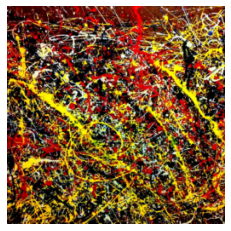

In [150]:
show_image(style_img)

Show the content image and the mask

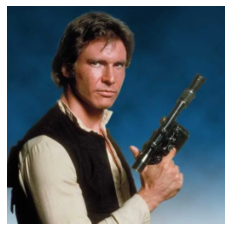

In [151]:
show_image(content_img)

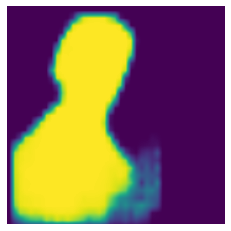

In [152]:
show_image(mask_img)

### Definition of the `StyleLoss` and `MaskedContentLoss` layers
---

In [11]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, x):
        self.loss = F.mse_loss(x, self.target)
        return x
        
        
def get_gram_matrix(layer_activations):
        batch_size, h, w, f_map_num = layer_activations.size()  # batch size(=1)
        # reshape feature tensor into matrix
        F = layer_activations.view(batch_size * f_map_num, w * h)  
        # construct Gram matrix
        G = F @ F.T 
        # normalize by the total number of elements
        return G.div(batch_size * h * w * f_map_num)
    
    
class StyleLoss(nn.Module):
    def __init__(self, style_img_features):
        super(StyleLoss, self).__init__()
        self.target_G = get_gram_matrix(style_img_features).detach()

    def forward(self, x):
        input_G = get_gram_matrix(x)
        self.loss = F.mse_loss(input_G, self.target_G)
        return x
    
class MaskedStyleLoss(nn.Module):
    def __init__(self, style_img_features, mask):
        super(MaskedStyleLoss, self).__init__()
        batch_size, n_channels, h, w = style_img_features.shape
        self.target_G = get_gram_matrix(style_img_features).detach()
        # due to the MaxPooling operations and strided convolutions the size on the intermediate layer can be smaller, that of the input image
        # resize the mask by interpolation function
        self.mask = F.interpolate(mask, size = (h, w))
        self.mask = self.mask.repeat(1, n_channels, 1, 1)

    def forward(self, x):
        x_masked = self.mask * x
        input_G = get_gram_matrix(x_masked)
        self.loss = F.mse_loss(input_G, self.target_G)
        return x

### Normalization
---

Normalization constants on the `Imagenet` set, one needs to do this, because the pretrained model has used these values

In [12]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406], requires_grad = False).to(device)
imagenet_std = torch.tensor([0.229, 0.224, 0.225], requires_grad = False).to(device)

In [13]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

### Definition of the `MaskedStyleTransfer` class

In [14]:
def get_input_optimizer(input_img, optimizer_type, **kwargs):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optimizer_type([input_img.requires_grad_()], **kwargs) 
        return optimizer

class MaskedStyleTransfer:
    def __init__(self, 
                 base_model, 
                 normalization_layer, 
                 content_layers, 
                 style_layers,
                 style_img, 
                 content_img,
                 mask_img,
                 style_weight = 1e2,
                 content_weight = 1e-2):\
        
        self.style_weight = style_weight
        self.content_weight = content_weight
        
        self.model = nn.Sequential(normalization_layer.to(device))
        self.content_losses = []
        self.style_losses = []
        current_content_layer = 0
        current_style_layer = 0
        i = 0
        
        for layer in base_model.children():
            if isinstance(layer, nn.Conv2d):
                name = f'conv_{i}'
                i += 1
            elif isinstance(layer, nn.ReLU):
                name = f'relu_{i}'
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = f'pool_{i}'
            elif isinstance(layer, nn.BatchNorm2d):
                name = f'bn_{i}'
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
                
            self.model.add_module(name, layer)
            
            if name in content_layers:
                # add content loss:
                content_img_features = self.model(content_img).detach()
                content_loss = ContentLoss(content_img_features)
                self.model.add_module(f"content_loss_{i}", content_loss)
                current_content_layer += 1
                self.content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                style_img_features = self.model(style_img).detach()
                style_loss = MaskedStyleLoss(style_img_features, mask_img)
                self.model.add_module(f"style_loss_{i}", style_loss)
                current_style_layer += 1
                self.style_losses.append(style_loss)
                
            if current_content_layer == len(content_layers) or current_style_layer == len(style_layers):
                break
                
    def get_loss(self, log = False):
        total_style_loss = 0
        total_content_loss = 0

        for sl in self.style_losses:
            total_style_loss += sl.loss
        for cl in self.content_losses:
            total_content_loss += cl.loss
            
        return self.style_weight * total_style_loss + self.content_weight * total_content_loss, total_style_loss, total_content_loss
                
                
    def __call__(self, input_img, optimizer_type=optim.Adam, num_steps=500, log_interval=20, **optimizer_kwargs):
        optimizer = get_input_optimizer(input_img, optimizer_type, **optimizer_kwargs)
        
        for epoch in range(num_steps):
            input_img.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            self.model(input_img)
            
            loss, style_loss, content_loss = self.get_loss()
            loss.backward()
            optimizer.step()
            
            if epoch % log_interval == 0:
                 print(f'Style Loss : {style_loss.item():4f} Content Loss: {content_loss.item():4f}')
            
         # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Init the base_model

In [15]:
base_model = models.vgg19(pretrained=True).features.to(device)
base_model.eval()

for param in base_model.parameters():
    param.requires_grad = False 

In [16]:
content_layers_default = ['conv_4', 'conv_7']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

normalization_layer = Normalization(imagenet_mean, imagenet_std)

<ipython-input-13-990918138254>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-13-990918138254>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


In [156]:
style_transfer = MaskedStyleTransfer(base_model, 
                                   normalization_layer, 
                                   content_layers_default,
                                   style_layers_default,
                                   style_img,
                                   content_img,
                                   mask_img, 
                                   style_weight = 1e3,
                                   content_weight = 1e-1)

Run optimization (`optim.Adam`, `optim.RMSprop`) do the job reasonably well

In [157]:
input_img = torch.zeros_like(style_img)
input_img = style_transfer(input_img, optimizer_type = optim.RMSprop, num_steps = 5000, log_interval = 100, momentum = 0.9)

Style Loss : 4.226554 Content Loss: 35.460472
Style Loss : 0.009627 Content Loss: 267.296722
Style Loss : 0.004931 Content Loss: 251.743942
Style Loss : 0.003291 Content Loss: 242.945374
Style Loss : 0.002769 Content Loss: 238.053925
Style Loss : 0.003257 Content Loss: 238.414108
Style Loss : 0.003373 Content Loss: 238.030167
Style Loss : 0.004723 Content Loss: 243.235107
Style Loss : 0.006797 Content Loss: 243.025604
Style Loss : 0.006630 Content Loss: 242.385849
Style Loss : 0.009712 Content Loss: 250.122681
Style Loss : 0.006048 Content Loss: 242.253693
Style Loss : 0.011847 Content Loss: 243.477890
Style Loss : 0.009261 Content Loss: 240.483398
Style Loss : 0.052778 Content Loss: 208.587219
Style Loss : 0.001787 Content Loss: 222.672852
Style Loss : 0.001820 Content Loss: 222.738312
Style Loss : 0.001821 Content Loss: 222.585083
Style Loss : 0.011296 Content Loss: 230.705978
Style Loss : 0.008183 Content Loss: 231.681885
Style Loss : 0.003093 Content Loss: 229.094421
Style Loss : 0

Render the resulting image. Set the `savefig = True` in order to save image and set the image name

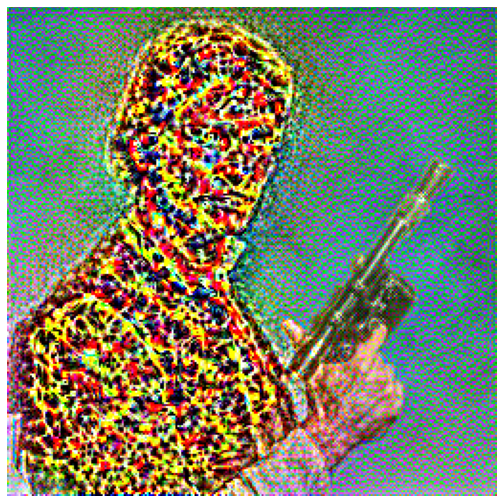

In [161]:
plt.figure(figsize = (9, 9))
show_image(input_img, savefig = True, saveimg_name = "images/han-solo_pollock.png")